## Processing the Data and Training a Topic Analysis Model

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import umap
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

import textwrap

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource,HoverTool
output_notebook()

Loading BokehJS ...

### Load Data

In [2]:
df = pd.read_pickle('data/EPMC/ffs_papers.pkl')
df.set_index('pmid',inplace=True)
df = df[~df.index.isna()]
print(len(df),'rows')
df.head()

1601 rows


,abstractText,authorList,chemicalList,citedByCount,doi,firstPublicationDate,grantsList,id,journalInfo,keywordList,meshHeadingList,pmcid,pubYear,title
pmid,,,,,,,,,,,,,,
30160348,The transepithelial potential difference (TEP)...,"[{'fullName': 'Cao L', 'firstName': 'Lin', 'la...",NaN,1,10.1111/jcmm.13829,2018-08-30,"[{'grantId': '1361/1362', 'agency': 'Fight for...",30160348,"{'issue': '11', 'volume': '22', 'journalIssueI...","[Atp1b1, Cell-cell Connection, Extracellular E...",NaN,PMC6201363,2018,Polarized retinal pigment epithelium generates...
30613630,NaN,"[{'fullName': 'Chen M', 'firstName': 'Mei', 'l...",NaN,0,10.21037/atm.2018.10.31,2018-11-01,"[{'grantId': '1425/26', 'agency': 'Fight for S...",30613630,"{'issue': 'Suppl 1', 'volume': '6', 'journalIs...",NaN,NaN,PMC6291610,2018,"Cholesterol homeostasis, macrophage malfunctio..."
29016458,PURPOSE:Quantitative analysis of hyperautofluo...,"[{'fullName': 'Tee JJL', 'firstName': 'James J...",NaN,0,10.1097/IAE.0000000000001871,2018-12-01,"[{'grantId': '1578/79', 'agency': 'Fight for S...",29016458,"{'issue': '12', 'volume': '38', 'journalIssueI...",NaN,NaN,PMC5797695,2018,QUANTITATIVE ANALYSIS OF HYPERAUTOFLUORESCENT ...
30634998,BACKGROUND:Uncontrolled microglial activation ...,"[{'fullName': 'Wang L', 'firstName': 'Luxi', '...",NaN,0,10.1186/s13024-019-0305-9,2019-01-11,"[{'grantId': '1361/62', 'agency': 'Fight for S...",30634998,"{'issue': '1', 'volume': '14', 'journalIssueId...","[Microglia, Retinal degeneration, neuroinflamm...",NaN,PMC6329071,2019,Glucose transporter 1 critically controls micr...
29164803,Cell therapy using endothelial progenitors hol...,"[{'fullName': 'Reid E', 'firstName': 'Emma', '...",NaN,4,10.1002/sctm.17-0187,2017-11-22,"[{'grantId': '10JTA', 'agency': 'The Sir Jules...",29164803,"{'issue': '1', 'volume': '7', 'journalIssueId'...","[Cell therapy, Stem Cells, Endothelial Progeni...",NaN,PMC5746158,2018,Preclinical Evaluation and Optimization of a C...


### Remove Missing or Extremely Short Abstracts

In [3]:
# remove missing abstracts
abstracts = df.loc[~df['abstractText'].isnull(),'abstractText']
abstracts = abstracts.dropna()

# remove abstracts less than 10 words in length
abstracts = abstracts[abstracts.str.split(r'[^a-zA-Z]+').str.len()>10]
pmids = abstracts.index

print(len(abstracts),'remaining abstracts')

1507 remaining abstracts


In [4]:
pmid_to_print = '24439297'
print_width = 120

def print_abstract(pmid=pmid_to_print, width=print_width):
    n_characters = len(abstracts[pmid])
    n_words = len(abstracts[pmid].split())
    
    print('-'*width)
    print('Example Abstract, PMID',pmid,
          '(',n_words,'words,',n_characters,'characters ):')
    print('-'*width)
    
    print(textwrap.fill(abstracts[pmid_to_print], width=width))
    print('-'*width)
    
print_abstract()

------------------------------------------------------------------------------------------------------------------------
Example Abstract, PMID 24439297 ( 349 words, 2367 characters ):
------------------------------------------------------------------------------------------------------------------------
Choroideremia is an X-linked recessive disease that leads to blindness due to mutations in the CHM gene, which encodes
the Rab escort protein 1 (REP1). We assessed the effects of retinal gene therapy with an adeno-associated viral (AAV)
vector encoding REP1 (AAV.REP1) in patients with this disease.In a multicentre clinical trial, six male patients (aged
35-63 years) with choroideremia were administered AAV.REP1 (0·6-1·0×10(10) genome particles, subfoveal injection).
Visual function tests included best corrected visual acuity, microperimetry, and retinal sensitivity tests for
comparison of baseline values with 6 months after surgery. This study is registered with ClinicalTrials.gov, num

### Remove Digits and Punctuation

In [5]:
# convert to lower case
abstracts = abstracts.str.lower()

# remove digits and punctuation
abstracts = abstracts.str.replace(r'[^a-zA-Z]+',' ',regex=True)

abstracts = abstracts.str.strip()

print_abstract()

------------------------------------------------------------------------------------------------------------------------
Example Abstract, PMID 24439297 ( 340 words, 2173 characters ):
------------------------------------------------------------------------------------------------------------------------
choroideremia is an x linked recessive disease that leads to blindness due to mutations in the chm gene which encodes
the rab escort protein rep we assessed the effects of retinal gene therapy with an adeno associated viral aav vector
encoding rep aav rep in patients with this disease in a multicentre clinical trial six male patients aged years with
choroideremia were administered aav rep genome particles subfoveal injection visual function tests included best
corrected visual acuity microperimetry and retinal sensitivity tests for comparison of baseline values with months after
surgery this study is registered with clinicaltrials gov number nct despite undergoing retinal detachment wh

### Remove Stop Words and Lemmatize

In [6]:
try:
    lemma = WordNetLemmatizer()
except:
    import nltk
    nltk.download('wordnet')
    lemma = WordNetLemmatizer()

try:
    stop_words = stopwords.words('english')
except:
    import nltk
    nltk.download('stopwords')
    stop_words = stopwords.words('english')
    
abstracts= abstracts.str.split(' ')
abstracts=abstracts.apply(lambda x : [lemma.lemmatize(word) for word in x if word not in stop_words])
abstracts=abstracts.apply(lambda x : ' '.join(x))

print_abstract()

------------------------------------------------------------------------------------------------------------------------
Example Abstract, PMID 24439297 ( 225 words, 1676 characters ):
------------------------------------------------------------------------------------------------------------------------
choroideremia x linked recessive disease lead blindness due mutation chm gene encodes rab escort protein rep assessed
effect retinal gene therapy adeno associated viral aav vector encoding rep aav rep patient disease multicentre clinical
trial six male patient aged year choroideremia administered aav rep genome particle subfoveal injection visual function
test included best corrected visual acuity microperimetry retinal sensitivity test comparison baseline value month
surgery study registered clinicaltrials gov number nct despite undergoing retinal detachment normally reduces vision two
patient advanced choroideremia low baseline best corrected visual acuity gained letter letter two fo

### Vectorise

In [7]:
countvec = CountVectorizer(strip_accents='unicode', lowercase=True, stop_words='english')

countvec.fit(abstracts)

print('Size of vocabulary:',len(countvec.vocabulary_))

count_vectors = countvec.transform(abstracts)
features = countvec.get_feature_names()

count_vectors = pd.DataFrame(count_vectors.toarray(),
                                index=abstracts.index,
                                columns=features)

Size of vocabulary: 13697


In [8]:
def print_abstract_counts(pmid=pmid_to_print, width=print_width):
    vector = count_vectors.loc[pmid]
    vector = vector[vector>0]
    vector = vector.sort_values(ascending=False)
    
    length = vector.sum()
    unique_words = len(vector.index)
    
    print('-'*width)
    print('Example Abstract, PMID',pmid,
          '(',length,'words long,',unique_words,'unique words ):')
    print('-'*width)
    
    print_str = ''
    for word,count in vector.items():
        print_str += str(count)+'*('+word+') + '

    print_str = print_str[:-2]
    
    print(textwrap.fill(print_str, width=width))
    print('-'*width)

print_abstract_counts()

------------------------------------------------------------------------------------------------------------------------
Example Abstract, PMID 24439297 ( 210 words long, 133 unique words ):
------------------------------------------------------------------------------------------------------------------------
8*(retinal) + 6*(patient) + 5*(visual) + 5*(sensitivity) + 5*(db) + 4*(letter) + 4*(gene) + 4*(acuity) + 4*(vector) +
4*(baseline) + 4*(rep) + 4*(choroideremia) + 3*(mean) + 3*(corrected) + 3*(eye) + 3*(disease) + 3*(best) +
3*(administered) + 3*(se) + 3*(aav) + 3*(therapy) + 2*(test) + 2*(increase) + 2*(maximal) + 2*(trial) + 2*(detachment) +
2*(treatment) + 2*(microperimetry) + 2*(effect) + 2*(surviving) + 2*(included) + 2*(month) + 2*(function) + 2*(treated)
+ 2*(vision) + 1*(despite) + 1*(dose) + 1*(eccentric) + 1*(ectopic) + 1*(subfoveal) + 1*(epithelium) + 1*(encodes) +
1*(encoding) + 1*(degeneration) + 1*(escort) + 1*(established) + 1*(exposed) + 1*(finding) + 1*(fixation)

### Vocabulary

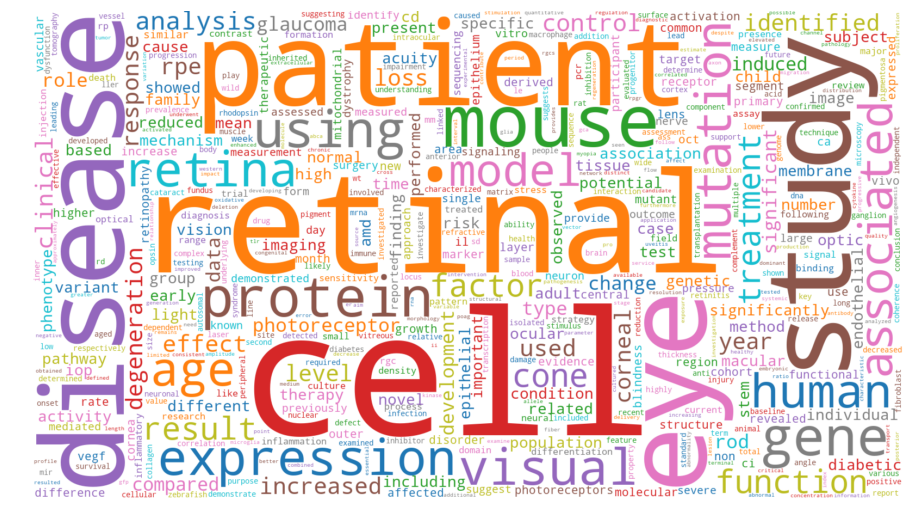

In [9]:
word_totals = count_vectors.sum(axis=0)

wordcloud = WordCloud(width=1600, 
                      height=900,
                      prefer_horizontal=0.9,
                      max_words=500,
                      min_font_size=8,
                      max_font_size=None,
                      font_step=1,
                      background_color='white',
                      relative_scaling='auto',
                      colormap='tab10').generate_from_frequencies(word_totals)

plt.figure(figsize=(16,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

### Word Frequencies

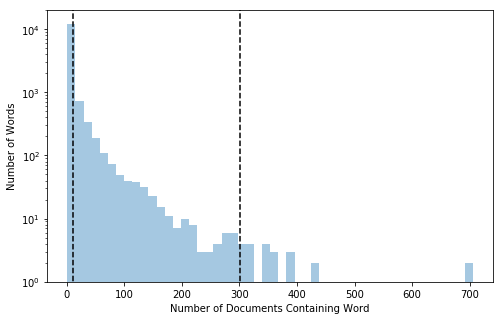

In [10]:
doc_counts = (count_vectors>0).sum(axis=0)

plt.figure(figsize=(8,5))
sns.distplot(doc_counts,kde=False, hist_kws={'log':True})
plt.xlabel('Number of Documents Containing Word')
plt.ylabel('Number of Words')

plt.plot([10,10],[0,2e4],'k--')
plt.plot([0.2*len(abstracts),0.2*len(abstracts)],[0,2e4],'k--')
plt.ylim([1,2e4]);

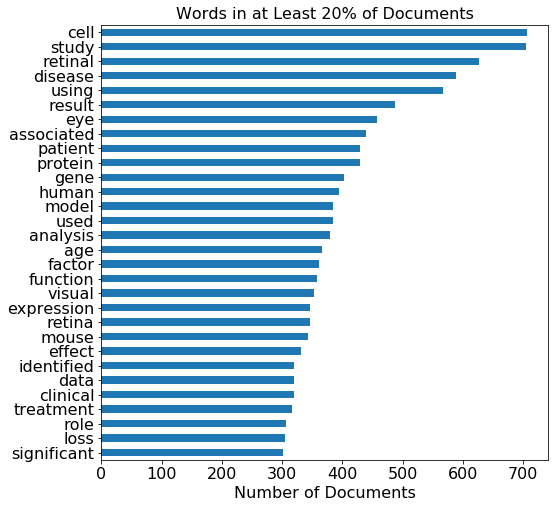

In [11]:
plt.figure(figsize=(8,8))
doc_counts[doc_counts>0.2*len(abstracts)].sort_values().plot.barh(fontsize=16)
plt.title('Words in at Least 20% of Documents',fontsize=16)
plt.xlabel('Number of Documents',fontsize=16);

### Exclude Most Common and Rare Words

Words that appear in less than 10 documents or more than 20% of documents.

In [12]:
countvec = CountVectorizer(strip_accents='unicode', lowercase=True, stop_words='english', 
                           max_df=0.2, min_df=10/len(abstracts))

countvec.fit(abstracts)

print('Size of vocabulary:',len(countvec.vocabulary_))
print('No. words excluded:',len(countvec.stop_words_))

count_vectors = countvec.transform(abstracts)
features = countvec.get_feature_names()

count_vectors = pd.DataFrame(count_vectors.toarray(),
                                index=abstracts.index,
                                columns=features)

print_abstract_counts()

Size of vocabulary: 2461
No. words excluded: 11236
------------------------------------------------------------------------------------------------------------------------
Example Abstract, PMID 24439297 ( 141 words long, 97 unique words ):
------------------------------------------------------------------------------------------------------------------------
5*(sensitivity) + 4*(letter) + 4*(acuity) + 4*(vector) + 4*(baseline) + 4*(choroideremia) + 4*(rep) + 3*(administered) +
3*(best) + 3*(corrected) + 3*(mean) + 3*(aav) + 3*(therapy) + 2*(test) + 2*(month) + 2*(trial) + 2*(detachment) +
2*(included) + 2*(surviving) + 2*(vision) + 2*(maximal) + 2*(treated) + 2*(increase) + 1*(recessive) + 1*(consistent) +
1*(control) + 1*(surgery) + 1*(correlated) + 1*(dark) + 1*(degeneration) + 1*(despite) + 1*(support) + 1*(dose) +
1*(encodes) + 1*(encoding) + 1*(epithelium) + 1*(escort) + 1*(established) + 1*(exposed) + 1*(finding) + 1*(contrast) +
1*(cone) + 1*(rab) + 1*(comparison) + 1*(viral) +

### Include bigrams

Pairs of words

Note: "retinal" removed as too common, but bigrams like "retinal detachment" can remain.

In [13]:
countvec = CountVectorizer(strip_accents='unicode', lowercase=True, stop_words='english', 
                           ngram_range=(1, 2), max_df=0.2, min_df=10/len(abstracts))

countvec.fit(abstracts)

print('size vocab:',len(countvec.vocabulary_))
print('no. stop words:',len(countvec.stop_words_))

count_vectors = countvec.transform(abstracts)
features = countvec.get_feature_names()

count_vectors = pd.DataFrame(count_vectors.toarray(),
                                index=abstracts.index,
                                columns=features)

print_abstract_counts()

size vocab: 3273
no. stop words: 149583
------------------------------------------------------------------------------------------------------------------------
Example Abstract, PMID 24439297 ( 176 words long, 121 unique words ):
------------------------------------------------------------------------------------------------------------------------
5*(sensitivity) + 4*(letter) + 4*(visual acuity) + 4*(acuity) + 4*(vector) + 4*(baseline) + 4*(choroideremia) + 4*(rep)
+ 3*(administered) + 3*(best) + 3*(best corrected) + 3*(corrected) + 3*(corrected visual) + 3*(gene therapy) + 3*(mean)
+ 3*(aav) + 3*(therapy) + 2*(test) + 2*(month) + 2*(surviving) + 2*(included) + 2*(increase) + 2*(detachment) +
2*(maximal) + 2*(treated eye) + 2*(trial) + 2*(treated) + 2*(retinal detachment) + 2*(vision) + 1*(encodes) +
1*(correlated) + 1*(adeno associated) + 1*(dark) + 1*(degeneration) + 1*(despite) + 1*(adeno) + 1*(disease age) +
1*(dose) + 1*(encoding) + 1*(advanced) + 1*(epithelium) + 1*(escort) + 1

### Updated Vocabulary

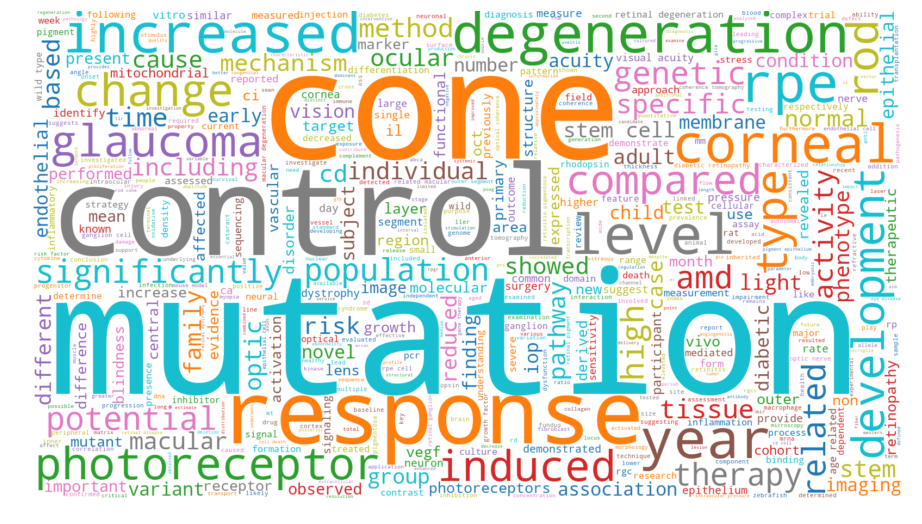

In [14]:
word_totals = count_vectors.sum(axis=0)

wordcloud = WordCloud(width=1600, 
                      height=900,
                      prefer_horizontal=0.9,
                      max_words=500,
                      min_font_size=8,
                      max_font_size=None,
                      font_step=1,
                      background_color='white',
                      relative_scaling='auto',
                      colormap='tab10').generate_from_frequencies(word_totals)

plt.figure(figsize=(16,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

### Train Topic Analysis Model (Latent Dirichlet Allocation)

In [15]:
lda = LatentDirichletAllocation(n_components=10,verbose=1)
lda.fit(count_vectors) 
print('--------------------')

lda_vectors = lda.transform(count_vectors)
lda_vectors = pd.DataFrame(lda_vectors,index=abstracts.index)

topics = pd.DataFrame(lda.components_,columns=features)
for key,topic in topics.iterrows():
    print_str = 'TOPIC '+str(key)+': '+str(topic.nlargest(6).index.values)
    print(textwrap.fill(print_str, width=print_width))

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
--------------------
TOPIC 0: ['mitochondrial' 'ca' 'activity' 'response' 'rod' 'stress']
TOPIC 1: ['diabetic' 'endothelial' 'vegf' 'vascular' 'iop' 'retinopathy']
TOPIC 2: ['year' 'population' 'prevalence' 'surgery' 'cataract' 'case']
TOPIC 3: ['image' 'oct' 'year' 'mean' 'test' 'acuity']
TOPIC 4: ['corneal' 'cd' 'il' 'epithelial' 'cornea' 'tissue']
TOPIC 5: ['amd' 'glaucoma' 'risk' 'association' 'genetic' 'cohort']
TOPIC 6: ['rpe' 'degeneration' 'stem' 'photoreceptor' 'therapy' 'stem cell']
TOPIC 7: ['rgc' 'ganglion' 'ganglion cell' 'ller' 'binding' 'retinal ganglion']
TOPIC 8: ['mutation' 'cone' 'family' 'variant' 'dystrophy' 'sequencing']
TOPIC 9: ['lens' 'child' 'research' 'development' 'method'

In [16]:
def print_abstract_topics(pmid=pmid_to_print, width=print_width):
    vector = lda_vectors.loc[pmid]
    vector = vector[vector>0.05]
    vector = vector.sort_values(ascending=False)

    
    print('-'*width)
    print('Example Abstract, PMID',pmid)
    print('-'*width)
    
    for topic, weight in vector.items():
        words = (topics.loc[topic]*count_vectors.loc[pmid_to_print])
        words = words.sort_values(ascending=False).head(5).index.values
        
        print_str = '{:.2f} * TOPIC {:d} {:s}'.format(weight,topic,str(words))
        print(textwrap.fill(print_str, width=width))

    print('-'*width)

print_abstract_topics()
print(textwrap.fill(df.loc[pmid_to_print,'abstractText'],width=120))

------------------------------------------------------------------------------------------------------------------------
Example Abstract, PMID 24439297
------------------------------------------------------------------------------------------------------------------------
0.51 * TOPIC 3 ['acuity' 'sensitivity' 'mean' 'visual acuity' 'baseline']
0.45 * TOPIC 6 ['therapy' 'vector' 'degeneration' 'gene therapy' 'aav']
------------------------------------------------------------------------------------------------------------------------
Choroideremia is an X-linked recessive disease that leads to blindness due to mutations in the CHM gene, which encodes
the Rab escort protein 1 (REP1). We assessed the effects of retinal gene therapy with an adeno-associated viral (AAV)
vector encoding REP1 (AAV.REP1) in patients with this disease.In a multicentre clinical trial, six male patients (aged
35-63 years) with choroideremia were administered AAV.REP1 (0·6-1·0×10(10) genome particles, subfoveal 

### Visualise Topics

UMAP: Dimensionality reduction technique. Converts 10-dimensional LDA vectors into 2-dimensional vectors appropriate for plotting, whilst trying to preserve relationships between topics in a meaningful way.

In [17]:
umapper = umap.UMAP()
X_umap = umapper.fit_transform(lda_vectors)

In [18]:
# extract majority topic for each publication and the words
# in that publication from that topic - for plotting.
max_topics = lda_vectors.idxmax(axis=1)
max_values = lda_vectors.max(axis=1)

max_words=pd.Series(index=abstracts.index)
for pmid,counts in count_vectors.iterrows():
    topic = topics.loc[max_topics.loc[pmid]]
    words = (counts*topic).nlargest(5).index
    max_words.loc[pmid] = ', '.join(words)

In [19]:
# create a new plot
p = figure(plot_width=800, plot_height=500)

colours = [
    "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*mpl.cm.hsv(mpl.colors.Normalize()(max_topics.values))
]

source = ColumnDataSource({'x':X_umap[:,0],'y':X_umap[:,1], 
                           'c':colours,
                           'pmid':abstracts.index,
                           'title':df.loc[abstracts.index,'title'],
                           'topic':max_topics,
                           'value':max_values,
                           'words':max_words})

p.circle(x='x', y='y',
         color='c',
         source = source,
         size=8, fill_alpha=0.3)

# tooltips
hover = HoverTool()
hover.tooltips = [
    ('PMID','@pmid'),('Title','@title'),('Topic','@topic (@value{0%})'), ('Keywords','@words')
]
p.tools.append(hover)

p.axis.visible = False
p.grid.visible = False

show(p) # show the results